<a href="https://colab.research.google.com/github/Aravinda89/OCR/blob/main/Use_EasyOCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EasyOCR
<img src="https://blog.kakaocdn.net/dn/pXiuH/btrqsGvQ5uj/ZV6LAYLk7YBYPp3REB9erk/img.jpg" height="200" title="EasyOCR" alt="EasyOCR"></img>

[EasyOCR][easy_ocr_link]은 문자 영역 인식(Detection), 문자 인식(Recognition)을 손쉽게 수행 할 수 있도록 하는 Python 패키지 입니다. EasyOCR은 구현이 간단하고 매우 직관적입니다. 현재 [80개이상의 언어][supported_lang_link]를 지원하고 있으며, 꾸준히 Releases 되고 있습니다. 

최근에는 손글씨 인식을 목표로 하고 있습니다.

[easy_ocr_link]: https://github.com/JaidedAI/EasyOCR "Go EasyOCR"
[supported_lang_link]: https://www.jaided.ai/easyocr/ "Go EasyOCR"

### Install the necessary packages

In [ ]:
!pip install easyocr
!pip install opencv-python-headless==4.1.2.30

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 70.8 MB 14 kB/s 
     |████████████████████████████████| 47.6 MB 14.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.8 MB 1.3 MB/s 
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.5.4.60
    Uninstalling opencv-python-headless-4.5.4.60:
      Successfully uninstalled opencv-python-headless-4.5.4.60


### Colab에 설치된 한글 폰트가 없기때문에 나눔고딕 폰트를 인스톨합니다.

In [ ]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq

Selecting previously unselected package fonts-nanum.
(Reading database ... 155632 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


In [ ]:
import matplotlib.font_manager as fm

sys_font=fm.findSystemFonts()

nanum_font = [f for f in sys_font if 'Nanum' in f]
nanum_font

['/usr/share/fonts/truetype/nanum/NanumBrush.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicEcoBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjoExtraBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunGothicUltraLight.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunpenR.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareEB.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjoEco.ttf',
 '/usr/share/fonts/truetype/nanum/NanumPen.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareR.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicEcoExtraBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicLight.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunpenB.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareB.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjoEcoBold.ttf',
 '/usr/share/fonts/truety

### Import Packages

In [ ]:
from matplotlib import pyplot as plt
from imutils.perspective import four_point_transform
from imutils.contours import sort_contours
import imutils
from easyocr import Reader
import cv2
import requests
import numpy as np
from PIL import ImageFont, ImageDraw, Image

### Function
Colab에서 이미지를 확인하기위한 Function과 [이전 자료][scan_ocr_link]에서 설명한 Scan 이미지로 변환하는 방법을 Function으로 만들어 사용하도록 하겠습니다. 추가로 OpenCV putText의 경우 한글지원이 되지 않기때문에 한글을 표기하기 위한 Function을 만들어 사용합니다.


[scan_ocr_link]: https://colab.research.google.com/drive/1Uz9N7BbVX6qNrpRGHGOcZuW0XY00a1iw#scrollTo=DBnitJHymyMs "Go Scan OCR"

In [ ]:
def plt_imshow(title='image', img=None, figsize=(8 ,5)):
    plt.figure(figsize=figsize)

    if type(img) == list:
        if type(title) == list:
            titles = title
        else:
            titles = []

            for i in range(len(img)):
                titles.append(title)

        for i in range(len(img)):
            if len(img[i].shape) <= 2:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_GRAY2RGB)
            else:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)

            plt.subplot(1, len(img), i + 1), plt.imshow(rgbImg)
            plt.title(titles[i])
            plt.xticks([]), plt.yticks([])

        plt.show()
    else:
        if len(img.shape) < 3:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.imshow(rgbImg)
        plt.title(title)
        plt.xticks([]), plt.yticks([])
        plt.show()


def make_scan_image(image, width, ksize=(5,5), min_threshold=75, max_threshold=200):
  image_list_title = []
  image_list = []

  image = imutils.resize(image, width=width)
  ratio = org_image.shape[1] / float(image.shape[1])

  # 이미지를 grayscale로 변환하고 blur를 적용
  # 모서리를 찾기위한 이미지 연산
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  blurred = cv2.GaussianBlur(gray, ksize, 0)
  edged = cv2.Canny(blurred, min_threshold, max_threshold)

  image_list_title = ['gray', 'blurred', 'edged']
  image_list = [gray, blurred, edged]

  # contours를 찾아 크기순으로 정렬
  cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

  findCnt = None

  # 정렬된 contours를 반복문으로 수행하며 4개의 꼭지점을 갖는 도형을 검출
  for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)

    # contours가 크기순으로 정렬되어 있기때문에 제일 첫번째 사각형을 영역으로 판단하고 break
    if len(approx) == 4:
      findCnt = approx
      break


  # 만약 추출한 윤곽이 없을 경우 오류
  if findCnt is None:
    raise Exception(("Could not find outline."))


  output = image.copy()
  cv2.drawContours(output, [findCnt], -1, (0, 255, 0), 2)
  
  image_list_title.append("Outline")
  image_list.append(output)

  # 원본 이미지에 찾은 윤곽을 기준으로 이미지를 보정
  transform_image = four_point_transform(org_image, findCnt.reshape(4, 2) * ratio)

  plt_imshow(image_list_title, image_list)
  plt_imshow("Transform", transform_image)

  return transform_image


def putText(cv_img, text, x, y, color=(0, 0, 0), font_size=22):
  # Colab이 아닌 Local에서 수행 시에는 gulim.ttc 를 사용하면 됩니다.
  # font = ImageFont.truetype("fonts/gulim.ttc", font_size)
  font = ImageFont.truetype('/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf', font_size)
  img = Image.fromarray(cv_img)
   
  draw = ImageDraw.Draw(img)
  draw.text((x, y), text, font=font, fill=color)

  cv_img = np.array(img)
  
  return cv_img

### Load Image

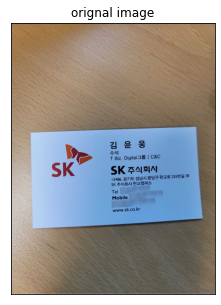

In [ ]:
url = 'https://user-images.githubusercontent.com/69428232/155486780-55525c3c-8f5f-4313-8590-dd69d4ce4111.jpg'

image_nparray = np.asarray(bytearray(requests.get(url).content), dtype=np.uint8)
org_image = cv2.imdecode(image_nparray, cv2.IMREAD_COLOR) 
plt_imshow("orignal image", org_image)

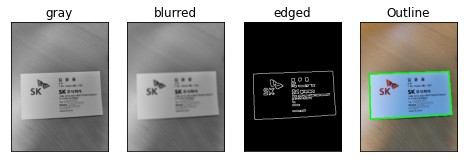

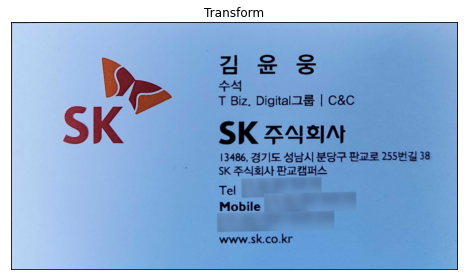

In [ ]:
business_card_image = make_scan_image(org_image, width=200, ksize=(5, 5), min_threshold=20, max_threshold=100)

### Using EasyOCR for Optical Character Recognition
EasyOCR의 사용은 매우 간단합니다. 언어와 GPU 사용여부를 선택하고 이미지를 넣기만 하면 됩니다. GPU 사용여부에 따라 속도차이가 있습니다. 경험해보기 위해 런타임 유형에서 하드웨어 가속을 ```None```으로 하여 수행해보고, 다시 ```GPU```로 변경하여 수행해보시기 바랍니다.

In [ ]:
langs = ['ko', 'en']

print("[INFO] OCR'ing input image...")
reader = Reader(lang_list=langs, gpu=True)
results = reader.readtext(business_card_image)

[INFO] OCR'ing input image...
Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.1% Complete

결과값은 추출된 글자에 대해 각 4개의 꼭지점 좌표(Top-Left, Top-Right, Bottom-Right, Bottom-Left)와 인식한 글자, 확률(Probability)을 리스트 형태로 Return 합니다.

In [ ]:
results

[([[710, 102], [1063, 102], [1063, 195], [710, 195]],
  '김 운 웅',
  0.6363422295539095),
 ([[714, 194], [806, 194], [806, 248], [714, 248]], '수석', 0.9967892928383479),
 ([[712, 244], [1196, 244], [1196, 300], [712, 300]],
  'T Biz. Digital그룹 | C8C',
  0.8564251970428666),
 ([[169, 279], [407, 279], [407, 437], [169, 437]], 'SK', 0.9998691786886823),
 ([[710, 334], [1168, 334], [1168, 438], [710, 438]],
  'SK 주식회사',
  0.9243429162602965),
 ([[714, 440], [1456, 440], [1456, 496], [714, 496]],
  '13486, 경기도 성남시 분당구 판교로 255번길 38',
  0.8064894547244771),
 ([[712, 488], [1098, 488], [1098, 542], [712, 542]],
  'SK 주식회사 판교캠퍼스',
  0.9777643971057438),
 ([[715, 561], [783, 561], [783, 605], [715, 605]], 'Tel', 0.9999751540302894),
 ([[716, 614], [868, 614], [868, 662], [716, 662]],
  'Mobile',
  0.999993916622258),
 ([[719, 731], [981, 731], [981, 773], [719, 773]],
  'WWWskcokr',
  0.7622629974254068)]

```detail=0```으로 설정하면 인식된 글자만 추출 List 형태로 Return 됩니다.

In [ ]:
simple_results = reader.readtext(business_card_image, detail = 0)
simple_results

['김 운 웅',
 '수석',
 'T Biz. Digital그룹 | C8C',
 'SK',
 'SK 주식회사',
 '13486, 경기도 성남시 분당구 판교로 255번길 38',
 'SK 주식회사 판교캠퍼스',
 'Tel',
 'Mobile',
 'WWWskcokr']

In [ ]:
# loop over the results
for (bbox, text, prob) in results:
  print("[INFO] {:.4f}: {}".format(prob, text))
  
  (tl, tr, br, bl) = bbox
  tl = (int(tl[0]), int(tl[1]))
  tr = (int(tr[0]), int(tr[1]))
  br = (int(br[0]), int(br[1]))
  bl = (int(bl[0]), int(bl[1]))

	# 추출한 영역에 사각형을 그리고 인식한 글자를 표기합니다.
  cv2.rectangle(business_card_image, tl, br, (0, 255, 0), 2)
  business_card_image = putText(business_card_image, text, tl[0], tl[1] - 60, (0, 255, 0), 50)
	# cv2.putText(business_card_image, text, (tl[0], tl[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

[INFO] 0.6363: 김 운 웅
[INFO] 0.9968: 수석
[INFO] 0.8564: T Biz. Digital그룹 | C8C
[INFO] 0.9999: SK
[INFO] 0.9243: SK 주식회사
[INFO] 0.8065: 13486, 경기도 성남시 분당구 판교로 255번길 38
[INFO] 0.9778: SK 주식회사 판교캠퍼스
[INFO] 1.0000: Tel
[INFO] 1.0000: Mobile
[INFO] 0.7623: WWWskcokr


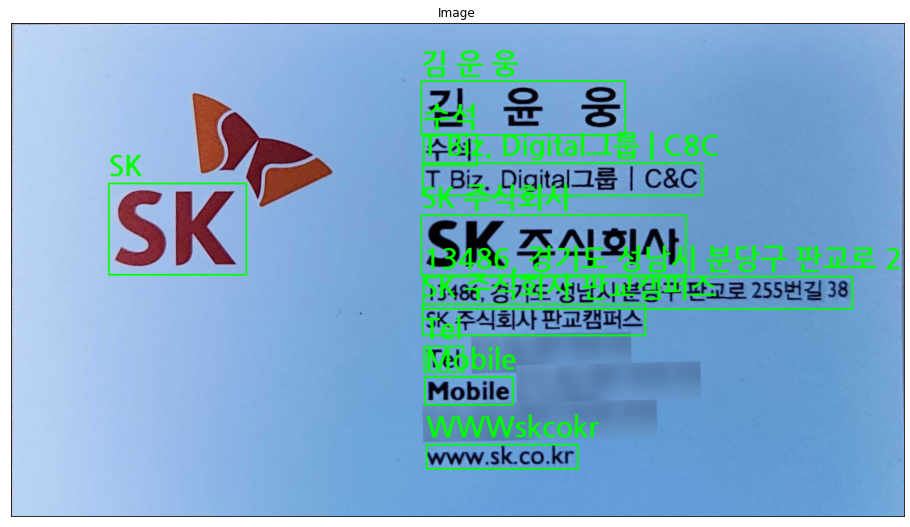

In [ ]:
# show the output image
plt_imshow("Image", business_card_image, figsize=(16,10))

약간 오인식된 글자도 있지만 인식이 나쁘지 않은 것 같습니다. 한글이라서 그럴 수 있다고 생각합니다. 영어는 꽤 괜찮네요.

(이름이..김..운..움..)